In [19]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # 0=all, 1=info, 2=warnings, 3=errors
import tensorflow as tf
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import silhouette_score
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.preprocessing import MinMaxScaler
from sklearn.manifold import TSNE
import umap
import plotly.express as px
import scipy.cluster.hierarchy as sch

In [20]:
# Загружаем данные
df = pd.read_csv("latent_features_expanded_with_type.csv")
df = df.dropna()

# Сохраняем метаданные
metadata_columns = df.columns[:2].tolist() + df.columns[-4:].tolist()
metadata = df[metadata_columns]

# Извлекаем только латентные признаки
X = df.iloc[:, 2:-4].values  # [688 x 3900]
print(f"Форма латентных признаков: {X.shape}")

Форма латентных признаков: (687, 3915)


In [21]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

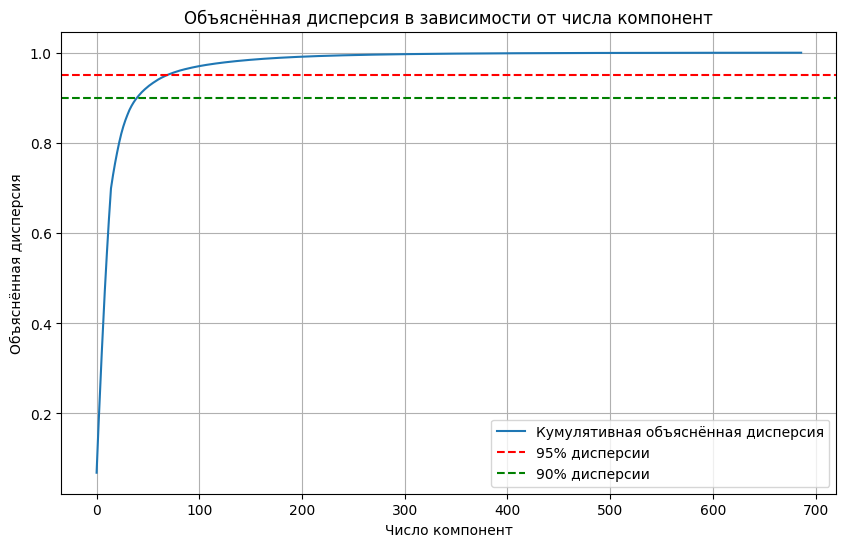

In [22]:
pca = PCA()
pca.fit(X_scaled)

# Накопленная объяснённая дисперсия
explained_variance = pca.explained_variance_ratio_.cumsum()

# Построение графика
plt.figure(figsize=(10, 6))
plt.plot(explained_variance, label='Кумулятивная объяснённая дисперсия')
plt.xlabel("Число компонент")
plt.ylabel("Объяснённая дисперсия")
plt.axhline(0.95, color='r', linestyle='--', label="95% дисперсии")
plt.axhline(0.90, color='g', linestyle='--', label="90% дисперсии")
plt.title("Объяснённая дисперсия в зависимости от числа компонент")
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Найдём минимальное число компонент для 95% дисперсии
n_components_95 = np.argmax(explained_variance >= 0.95) + 1
print(f"Для 95% дисперсии достаточно {n_components_95} компонент")

Для 95% дисперсии достаточно 70 компонент


In [24]:
pca = PCA(n_components=n_components_95)
X_reduced = pca.fit_transform(X_scaled)
print(f"Новая форма: {X_reduced.shape}")

Новая форма: (687, 70)


In [25]:
# Преобразуем пониженные признаки в DataFrame
reduced_df = pd.DataFrame(X_reduced, columns=[f"feature_{i}" for i in range(n_components_95)])

# Объединяем метаданные и новые признаки
final_df = pd.concat([metadata.reset_index(drop=True), reduced_df], axis=1)

# Сохраняем результат
# final_df.to_csv("latent_features_reduced_to_70_PCA.csv", index=False)

In [26]:
numeric_cols = final_df.select_dtypes(include=['float64']).columns
X = final_df[numeric_cols]

mms = MinMaxScaler()
X_scaled=mms.fit_transform(X)

In [27]:
X_scaled

array([[0.24930764, 0.15933145, 0.12260012, ..., 0.51036695, 0.54863917,
        0.51976454],
       [0.64222748, 0.55817067, 0.15090334, ..., 0.40300791, 0.39170749,
        0.44157291],
       [0.33929895, 0.70114007, 0.24053021, ..., 0.40891572, 0.60327972,
        0.32265958],
       ...,
       [0.51916118, 0.08242583, 0.10939195, ..., 0.13586053, 0.26324797,
        0.484215  ],
       [0.26324995, 0.23280183, 0.18675409, ..., 0.18947282, 0.61753162,
        0.46293489],
       [0.72207893, 0.63362674, 0.45280438, ..., 0.45507776, 0.28291135,
        0.36183099]])

In [28]:
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Добавление координат UMAP в DataFrame
df_vis = final_df.copy()
df_vis['umap_x'] = embedding[:, 0]
df_vis['umap_y'] = embedding[:, 1]
df_vis['umap_z'] = embedding[:, 2]

# Визуализация с Plotly
fig = px.scatter_3d(
    df_vis,
    x='umap_x',
    y='umap_y',
    z='umap_z',
    color='type',              # Цвет по типам структур
    hover_data=['type'],   # При наведении показывать имя файла
    title='Распределение данных в 3D (UMAP), цвет — тип структуры',
    labels={'umap_x': 'UMAP 1', 'umap_y': 'UMAP 2', 'umap_z': 'UMAP 3'},
    width=1000,
    height=800
)

# Настройка внешнего вида
fig.update_layout(
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.1)  # Позиция камеры (можно настроить)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=30)  # Отступы
)

fig.show()

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



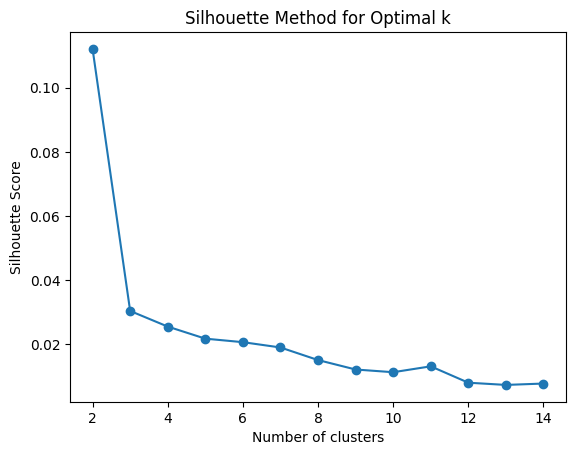

In [29]:
silhouette_scores = []
k_range = range(2, 15)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    silhouette_scores.append(score)

plt.plot(k_range, silhouette_scores, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.show()

In [30]:
kmeans = KMeans(n_clusters=3, random_state=42, n_init='auto')
clusters_kmeans = kmeans.fit_predict(X_scaled)

# Добавляем кластеры в датафрейм
final_df['K-Means'] = clusters_kmeans

In [31]:
score = silhouette_score(X_scaled, final_df['K-Means'])
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0304


In [36]:
def analyze_clusters(df, cluster_col, n_features=10):
    # Для каждого кластера находим наиболее важные признаки
    for cluster in sorted(df[cluster_col].unique()):
        print(f"\nАнализ кластера {cluster}:")
        cluster_data = df[df[cluster_col] == cluster]
        
        # Средние значения по кластеру
        means = cluster_data.mean(numeric_only=True)
        
        # Находим признаки, которые наиболее отличаются от общего среднего
        global_means = df.mean(numeric_only=True)
        diff = (means - global_means).abs().sort_values(ascending=False)
        
        print("Топ отличительных признаков:")
        print(diff.head(n_features))
        
        # Дополнительная статистика по кластеру
        print(f"\nРазмер кластера: {len(cluster_data)}")
        print("Географическое распределение (если есть координаты):")
        if 'Latitude' in df.columns and 'Longitude' in df.columns:
            print(f"Средняя широта: {cluster_data['Latitude'].mean()}")
            print(f"Средняя долгота: {cluster_data['Longitude'].mean()}")
            

# Анализируем K-Means кластеры
analyze_clusters(final_df, 'K-Means')


Анализ кластера 0:
Топ отличительных признаков:
Longitude     65.926744
Min_D_km      35.288217
Max_D_km      34.661328
Latitude       2.075289
feature_12     0.834972
feature_3      0.742135
K-Means        0.736536
feature_2      0.633008
feature_29     0.546845
feature_6      0.536955
dtype: float64

Размер кластера: 404
Географическое распределение (если есть координаты):
Средняя широта: 1.8422846534653463
Средняя долгота: -106.22152722772277

Анализ кластера 1:
Топ отличительных признаков:
Min_D_km      310.403202
Max_D_km      274.728622
Longitude      36.762683
Latitude       28.533929
feature_8       5.685885
feature_7       4.195947
feature_11      4.104419
feature_13      3.591848
feature_1       3.179577
feature_16      2.756455
dtype: float64

Размер кластера: 60
Географическое распределение (если есть координаты):
Средняя широта: -28.766933333333334
Средняя долгота: -3.5321

Анализ кластера 2:
Топ отличительных признаков:
Longitude     109.545487
Min_D_km       19.586334
M

type     cor  vlc  vlcInt
K-Means                  
0        237   90      77
1         60    0       0
2        148   46      29


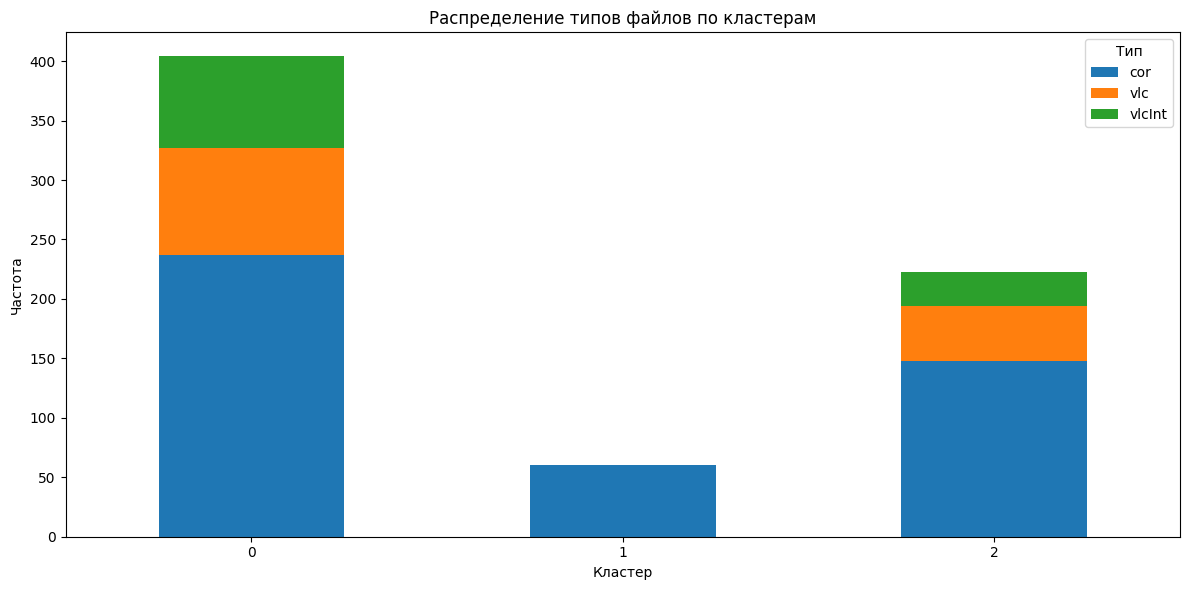

In [34]:
# Таблица распределения типов по кластерам
distribution = final_df.groupby('K-Means')['type'].value_counts().unstack(fill_value=0)
print(distribution)

# График
distribution.plot(kind='bar', stacked=True, figsize=(12, 6), title='Распределение типов файлов по кластерам')
plt.xlabel("Кластер")
plt.ylabel("Частота")
plt.xticks(rotation=0)
plt.legend(title='Тип')
plt.tight_layout()
plt.show()

In [17]:
# Понижение размерности до 3D с помощью UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Создаем датафрейм для визуализации
data_vis = pd.DataFrame(embedding, columns=['UMAP_x', 'UMAP_y', 'UMAP_z'])
data_vis['Cluster'] = clusters_kmeans.astype(str)  # Преобразуем кластеры в строки для легенды
data_vis['type'] = final_df.iloc[:, 1].values      # Типы объектов: cor, vlc, vlcInt

# Добавляем колонку для уникального сочетания Cluster + type
data_vis['group'] = data_vis['Cluster'] + '_' + data_vis['type']

# Строим график, где цвет зависит от кластера, форма — от типа
fig = px.scatter_3d(
    data_vis,
    x='UMAP_x',
    y='UMAP_y',
    z='UMAP_z',
    color='Cluster',
    symbol='type',
    hover_data=['type'],
    title='Кластеры в 3D (UMAP), разные формы точек по "type"',
    width=1000,
    height=800
)

# Настройка внешнего вида
fig.update_layout(
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3',
        camera=dict(
            eye=dict(x=1.5, y=1.5, z=0.1)  # Позиция камеры (можно настроить)
        )
    ),
    margin=dict(l=0, r=0, b=0, t=30)  # Отступы
)

fig.show()

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [18]:
import plotly.graph_objects as go
import pandas as pd

# Понижение размерности до 3D с помощью UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Создаем датафрейм для визуализации
data_vis = pd.DataFrame(embedding, columns=['UMAP_x', 'UMAP_y', 'UMAP_z'])
data_vis['Cluster'] = clusters_kmeans.astype(str)  # Преобразуем кластеры в строки для легенды
data_vis['type'] = final_df.iloc[:, 1].values      # Типы объектов: cor, vlc, vlcInt

# Цвета для кластеров
cluster_colors = {'0': 'red', '1': 'blue', '2': 'green'}

# Символы для типов объектов
symbols = {'cor': 'circle', 'vlc': 'square', 'vlcInt': 'diamond'}

# Создаем фигуру
fig = go.Figure()

# Добавляем точки по группам (кластер + тип)
for cluster in data_vis['Cluster'].unique():
    for obj_type in data_vis['type'].unique():
        subset = data_vis[(data_vis['Cluster'] == cluster) & (data_vis['type'] == obj_type)]
        fig.add_trace(go.Scatter3d(
            x=subset['UMAP_x'],
            y=subset['UMAP_y'],
            z=subset['UMAP_z'],
            mode='markers',
            marker=dict(
                size=6,
                color=cluster_colors[cluster],
                symbol=symbols[obj_type],
                line=dict(width=1, color='black')
            ),
            name=f'Cluster {cluster} - {obj_type}',
            legendgroup=f'Cluster {cluster}',  # Группируем по кластерам
            showlegend=True
        ))

# Настройка легенды: делим на две части
# --- Легенда для кластеров ---
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Кластеры'
))

# --- Легенда для форм ---
for obj_type in symbols:
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=10, color='gray', symbol=symbols[obj_type]),
        name=obj_type,
        legendgroup=obj_type,
        showlegend=True
    ))

# Обновляем layout
fig.update_layout(
    title='Кластеры в 3D (UMAP), разные формы точек по "type"',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend=dict(title="Цвет: Кластеры | Форма: Тип объекта"),
    width=1000,
    height=800
)

fig.show()

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



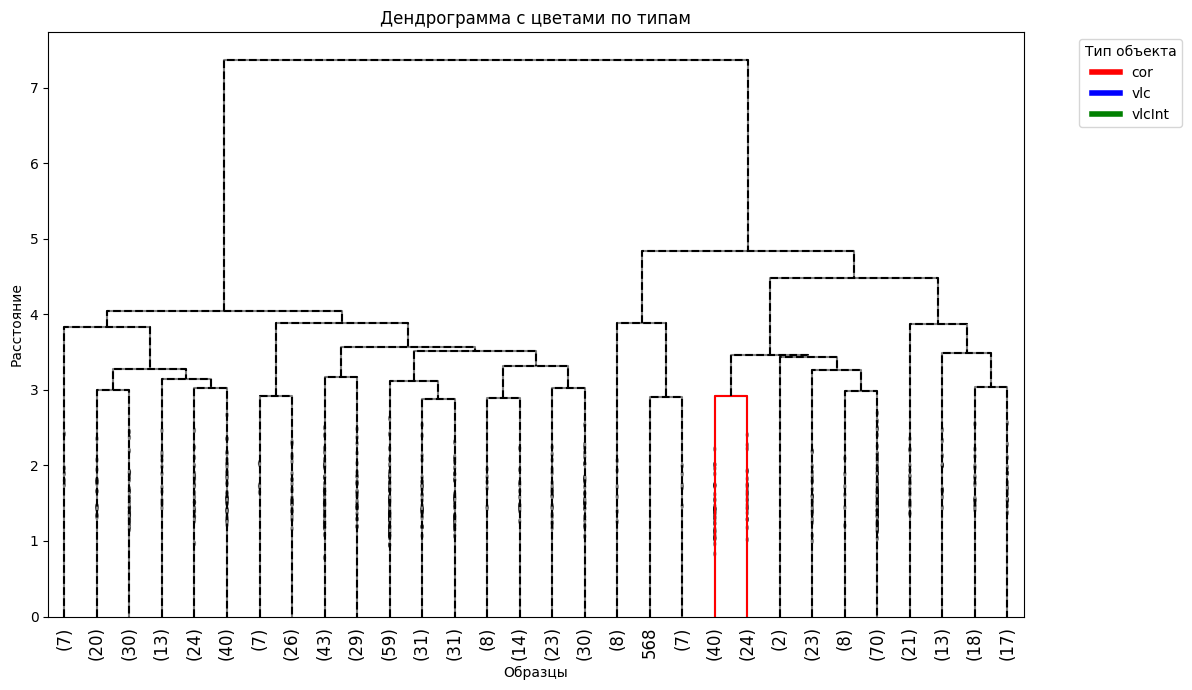

In [27]:
import scipy.cluster.hierarchy as sch
import matplotlib.pyplot as plt

# Цвета по типам
color_map = {'cor': 'red', 'vlc': 'blue', 'vlcInt': 'green'}
labels = final_df['type'].values  # ['cor', 'vlc', ...]
colors = [color_map[label] for label in labels]

# Строим linkage matrix
Z = sch.linkage(X_scaled, method='ward')

plt.figure(figsize=(12, 7))
dendro = sch.dendrogram(
    Z,
    truncate_mode='lastp',
    p=30,  # количество отображаемых листьев
    show_leaf_counts=True,
    leaf_rotation=90.,
    leaf_font_size=12.,
    show_contracted=True,
    color_threshold=0,
    above_threshold_color='gray'
)

# Получаем реальные индексы листьев, отображённых на графике
leaves = dendro['leaves']

# Окрашиваем связи по типам листьев
xcoords = dendro['icoord']
ycoords = dendro['dcoord']

for i, (xs, ys) in enumerate(zip(xcoords, ycoords)):
    if i < len(leaves):
        leaf_index = leaves[i]
        if leaf_index < len(colors):  # Защита от выхода за границы
            plt.plot(xs, ys, c=colors[leaf_index], linewidth=1.5)
        else:
            plt.plot(xs, ys, c='black', linestyle='--')
    else:
        plt.plot(xs, ys, c='black', linestyle='--')

# Добавляем легенду вручную
handles = [plt.Line2D([0], [0], color=color, lw=4, label=label) for label, color in color_map.items()]
plt.legend(handles=handles, title="Тип объекта", bbox_to_anchor=(1.05, 1), loc='upper left')

plt.title("Дендрограмма с цветами по типам")
plt.xlabel("Образцы")
plt.ylabel("Расстояние")
plt.tight_layout()
plt.show()

In [28]:
n_clusters = 3

clusterer = AgglomerativeClustering(n_clusters=n_clusters, affinity='euclidean', linkage='ward')
clusters_agg = clusterer.fit_predict(X_scaled)

# Добавляем кластеры в датафрейм
final_df['AggClust'] = clusters_agg

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [29]:
score = silhouette_score(X_scaled, clusters_agg)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0245


/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



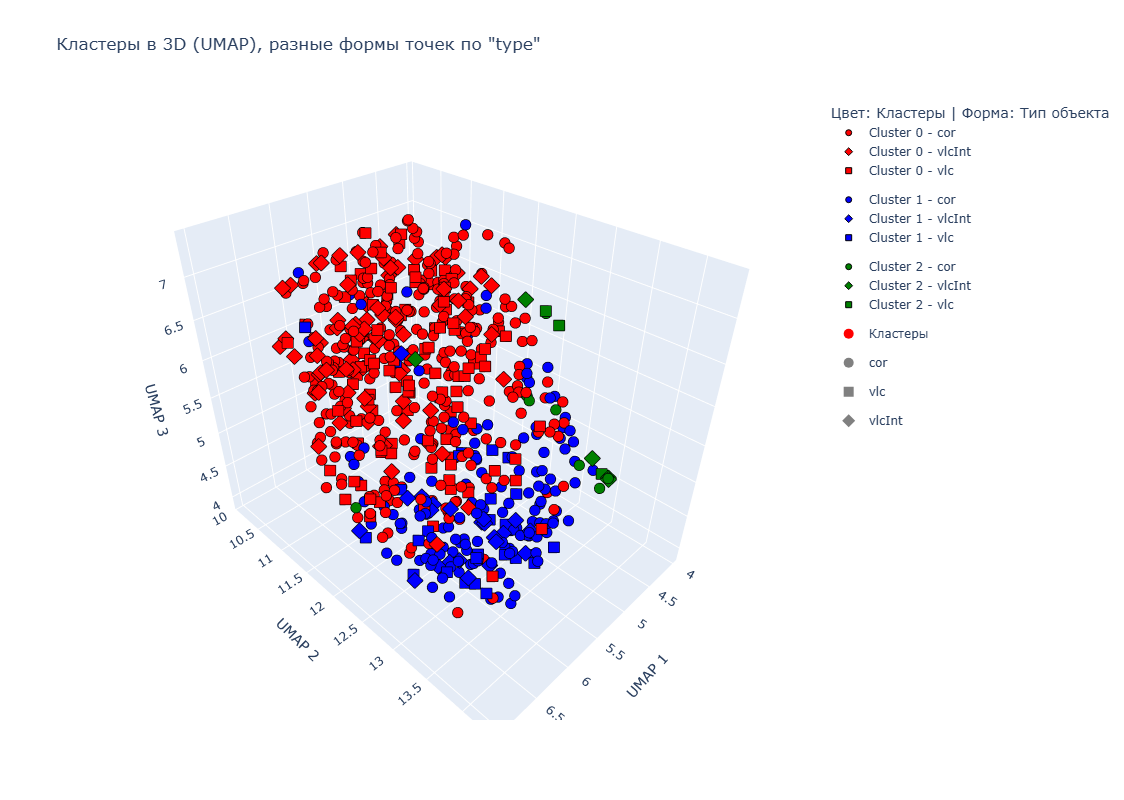

In [30]:
import plotly.graph_objects as go

# Понижение размерности до 3D с помощью UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Создаем датафрейм для визуализации
data_vis = pd.DataFrame(embedding, columns=['UMAP_x', 'UMAP_y', 'UMAP_z'])
data_vis['Cluster'] = clusters_agg.astype(str)  # Преобразуем кластеры в строки для легенды
data_vis['type'] = final_df.iloc[:, 1].values      # Типы объектов: cor, vlc, vlcInt

# Цвета для кластеров
cluster_colors = {'0': 'red', '1': 'blue', '2': 'green'}

# Символы для типов объектов
symbols = {'cor': 'circle', 'vlc': 'square', 'vlcInt': 'diamond'}

# Создаем фигуру
fig = go.Figure()

# Добавляем точки по группам (кластер + тип)
for cluster in data_vis['Cluster'].unique():
    for obj_type in data_vis['type'].unique():
        subset = data_vis[(data_vis['Cluster'] == cluster) & (data_vis['type'] == obj_type)]
        fig.add_trace(go.Scatter3d(
            x=subset['UMAP_x'],
            y=subset['UMAP_y'],
            z=subset['UMAP_z'],
            mode='markers',
            marker=dict(
                size=6,
                color=cluster_colors[cluster],
                symbol=symbols[obj_type],
                line=dict(width=1, color='black')
            ),
            name=f'Cluster {cluster} - {obj_type}',
            legendgroup=f'Cluster {cluster}',  # Группируем по кластерам
            showlegend=True
        ))

# Настройка легенды: делим на две части
# --- Легенда для кластеров ---
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Кластеры'
))

# --- Легенда для форм ---
for obj_type in symbols:
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=10, color='gray', symbol=symbols[obj_type]),
        name=obj_type,
        legendgroup=obj_type,
        showlegend=True
    ))

# Обновляем layout
fig.update_layout(
    title='Кластеры в 3D (UMAP), разные формы точек по "type"',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend=dict(title="Цвет: Кластеры | Форма: Тип объекта"),
    width=1000,
    height=800
)

fig.show()

type      cor  vlc  vlcInt
AggClust                  
0         296  106      79
1         141   27      22
2           8    3       5


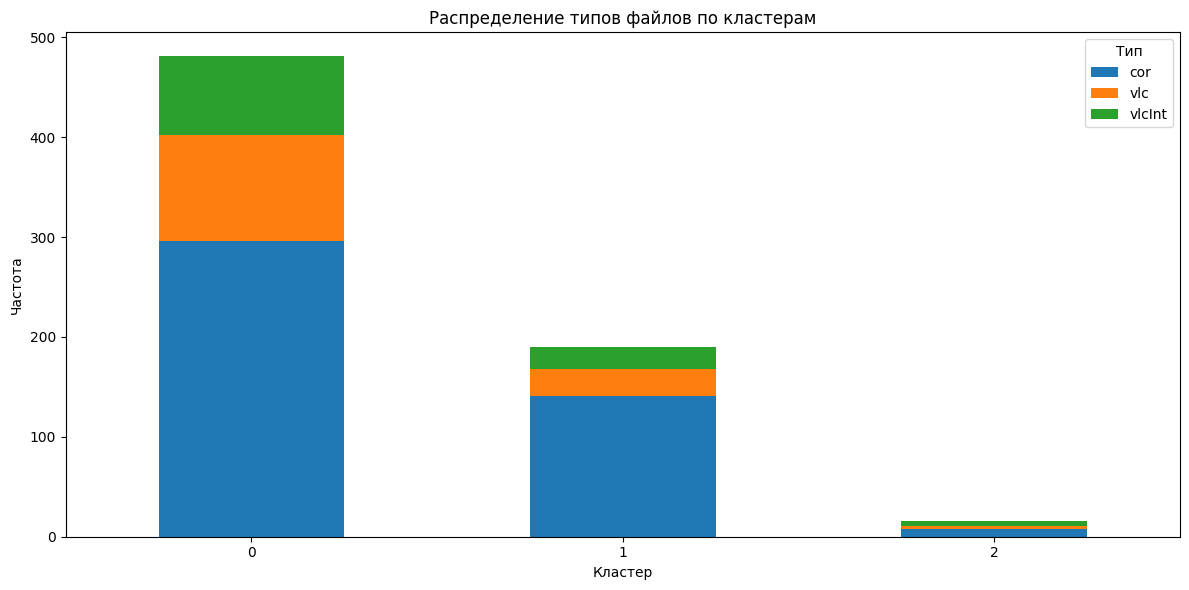

In [27]:
# Таблица распределения типов по кластерам
distribution = final_df.groupby('AggClust')['type'].value_counts().unstack(fill_value=0)
print(distribution)

# График
distribution.plot(kind='bar', stacked=True, figsize=(12, 6), title='Распределение типов файлов по кластерам')
plt.xlabel("Кластер")
plt.ylabel("Частота")
plt.xticks(rotation=0)
plt.legend(title='Тип')
plt.tight_layout()
plt.show()

In [27]:
# Средние значения признаков по кластерам
cluster_means = df.groupby('AggClust').mean()
print(cluster_means)

          features_SAR_0  features_SAR_1  ...    Max_D_km    Min_D_km
AggClust                                  ...                        
0               0.005086        0.007288  ...  226.719745  124.602041
1               0.008739        0.010443  ...  245.182890  153.582418
2               0.002900        0.005327  ...  226.468010  126.473510

[3 rows x 3919 columns]


/tmp/ipykernel_3294/2562217377.py:2: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [29]:
# Анализ кластеров
# Укажите интересующие вас столбцы
selected_columns = ['Latitude', 'Longitude']

# Анализ только выбранных признаков
cluster_stats = df.groupby('AggClust')[selected_columns].agg(
    ['mean', 'min', 'max', 'std']
)

print("Статистики по кластерам:")
print(cluster_stats)

Статистики по кластерам:
          Latitude                  ... Longitude                    
              mean     min     max  ...       min      max        std
AggClust                            ...                              
0        -4.295231 -78.039  79.754  ...  -170.380  177.355  96.072592
1         2.236538 -76.500  79.300  ...  -165.940  175.000  90.840397
2         2.977480 -70.000  76.074  ...  -175.168  176.500  99.321730

[3 rows x 8 columns]


In [30]:
# Анализ кластеров
# Укажите интересующие вас столбцы
selected_columns = ['Max_D_km', 'Min_D_km']

# Анализ только выбранных признаков
cluster_stats = df.groupby('AggClust')[selected_columns].agg(
    ['mean', 'min', 'max', 'std']
)

print("Статистики по кластерам:")
print(cluster_stats)

Статистики по кластерам:
            Max_D_km                  ... Min_D_km                    
                mean     min     max  ...      min     max         std
AggClust                              ...                             
0         226.719745  20.050   870.0  ...      0.0   750.0  154.877673
1         245.182890  20.188  1060.0  ...      0.0  1060.0  196.743887
2         226.468010  20.234  1080.0  ...      0.0   780.0  146.888677

[3 rows x 8 columns]


In [2]:
# # Сохранение результатов
# df = df.sort_values(by='Cluster', ascending=True)
# df.to_csv('hierarchical_clustered_data.csv', index=False)
# print("Результаты сохранены в hierarchical_clustered_data.csv")

In [31]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3, random_state=42)
clusters_gmm = gmm.fit_predict(X_scaled)

df['GMM'] = clusters_gmm

In [32]:
score = silhouette_score(X_scaled, clusters_gmm)
print(f"Silhouette Score: {score:.4f}")

Silhouette Score: 0.0308


type  cor  vlc  vlcInt
GMM                   
0     246   92      73
1      49    0       0
2     150   44      33


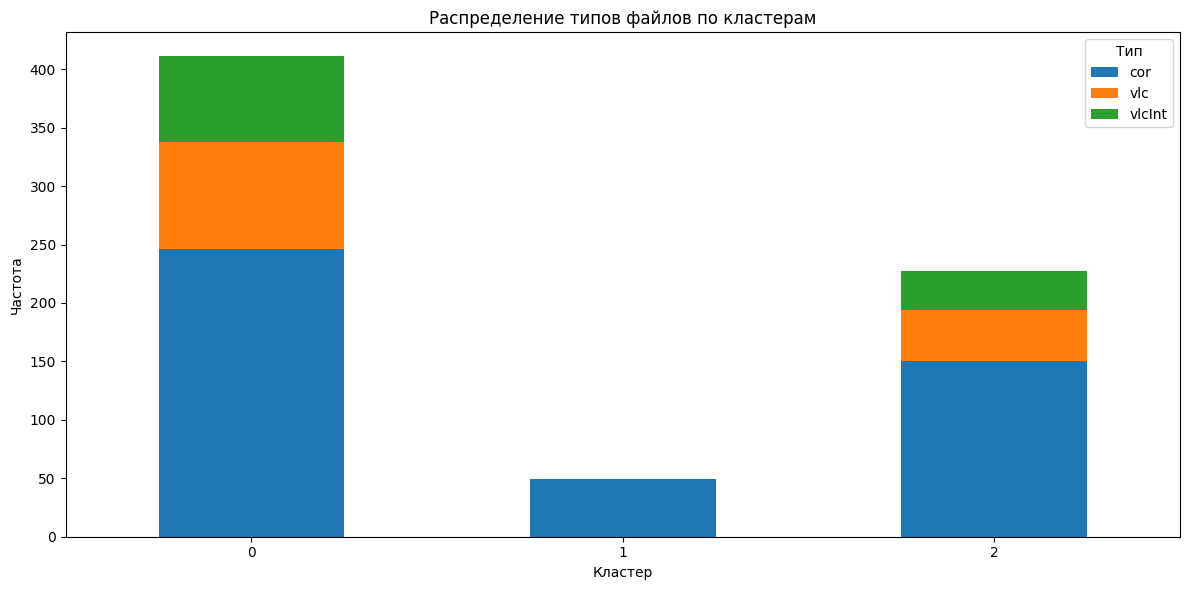

In [33]:
# Таблица распределения типов по кластерам
distribution = df.groupby('GMM')['type'].value_counts().unstack(fill_value=0)
print(distribution)

# График
distribution.plot(kind='bar', stacked=True, figsize=(12, 6), title='Распределение типов файлов по кластерам')
plt.xlabel("Кластер")
plt.ylabel("Частота")
plt.xticks(rotation=0)
plt.legend(title='Тип')
plt.tight_layout()
plt.show()

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



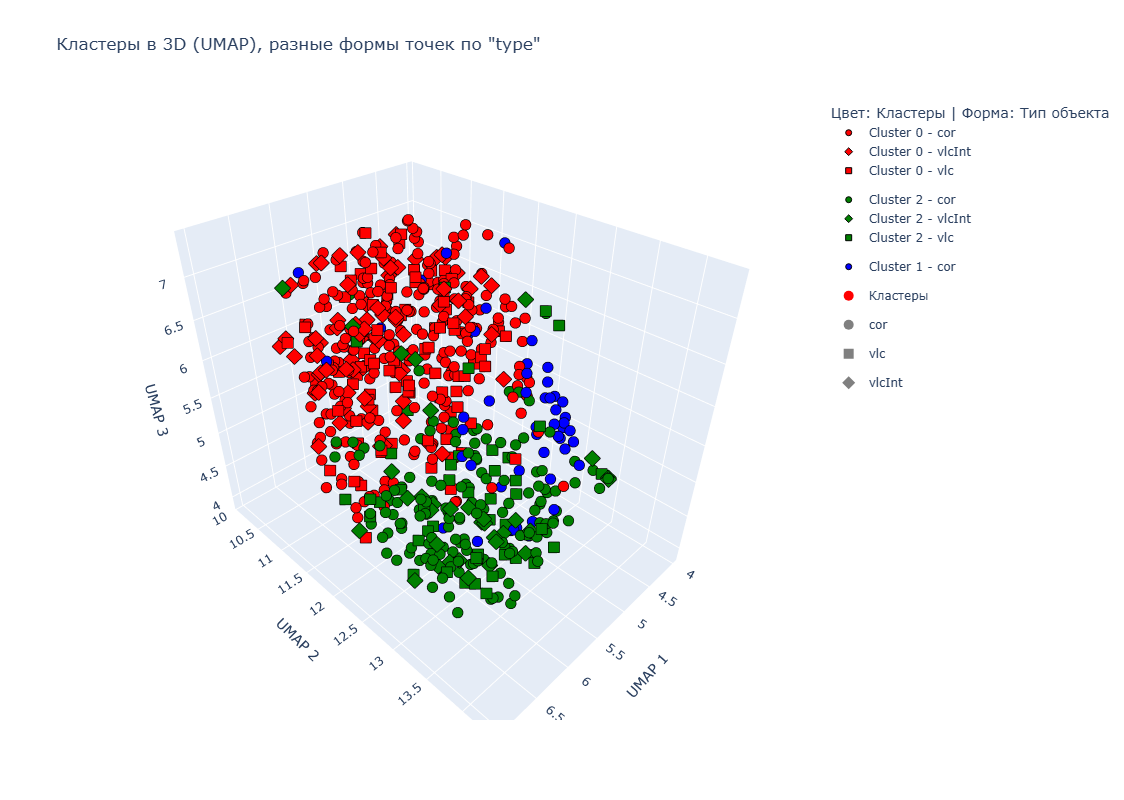

In [34]:
import plotly.graph_objects as go

# Понижение размерности до 3D с помощью UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Создаем датафрейм для визуализации
data_vis = pd.DataFrame(embedding, columns=['UMAP_x', 'UMAP_y', 'UMAP_z'])
data_vis['Cluster'] = clusters_gmm.astype(str)  # Преобразуем кластеры в строки для легенды
data_vis['type'] = final_df.iloc[:, 1].values      # Типы объектов: cor, vlc, vlcInt

# Цвета для кластеров
cluster_colors = {'0': 'red', '1': 'blue', '2': 'green'}

# Символы для типов объектов
symbols = {'cor': 'circle', 'vlc': 'square', 'vlcInt': 'diamond'}

# Создаем фигуру
fig = go.Figure()

# Добавляем точки по группам (кластер + тип)
for cluster in data_vis['Cluster'].unique():
    for obj_type in data_vis['type'].unique():
        subset = data_vis[(data_vis['Cluster'] == cluster) & (data_vis['type'] == obj_type)]
        fig.add_trace(go.Scatter3d(
            x=subset['UMAP_x'],
            y=subset['UMAP_y'],
            z=subset['UMAP_z'],
            mode='markers',
            marker=dict(
                size=6,
                color=cluster_colors[cluster],
                symbol=symbols[obj_type],
                line=dict(width=1, color='black')
            ),
            name=f'Cluster {cluster} - {obj_type}',
            legendgroup=f'Cluster {cluster}',  # Группируем по кластерам
            showlegend=True
        ))

# Настройка легенды: делим на две части
# --- Легенда для кластеров ---
fig.add_trace(go.Scatter3d(
    x=[None], y=[None], z=[None],
    mode='markers',
    marker=dict(size=10, color='red'),
    name='Кластеры'
))

# --- Легенда для форм ---
for obj_type in symbols:
    fig.add_trace(go.Scatter3d(
        x=[None], y=[None], z=[None],
        mode='markers',
        marker=dict(size=10, color='gray', symbol=symbols[obj_type]),
        name=obj_type,
        legendgroup=obj_type,
        showlegend=True
    ))

# Обновляем layout
fig.update_layout(
    title='Кластеры в 3D (UMAP), разные формы точек по "type"',
    scene=dict(
        xaxis_title='UMAP 1',
        yaxis_title='UMAP 2',
        zaxis_title='UMAP 3'
    ),
    legend=dict(title="Цвет: Кластеры | Форма: Тип объекта"),
    width=1000,
    height=800
)

fig.show()

In [43]:
from hdbscan import HDBSCAN

clusterer = HDBSCAN(
    min_cluster_size=4,
    min_samples=2,
    cluster_selection_method='leaf',
    metric='euclidean'
)
clusters = clusterer.fit_predict(X_scaled)
final_df['DBSCAN'] = clusters
print(np.unique(clusters, return_counts=True))

(array([-1,  0,  1,  2]), array([660,   4,  11,  12]))


In [33]:
mask = clusters != -1
if mask.sum() > 1 and len(np.unique(clusters[mask])) > 1:
    score = silhouette_score(X_scaled[mask], clusters[mask])
    print(f"Silhouette Score: {score:.4f}")
else:
    print("Недостаточно кластеров для вычисления Silhouette Score")

Silhouette Score: 0.1013


In [36]:
# Понижение размерности до 3D с помощью UMAP
reducer = umap.UMAP(n_components=3, random_state=42)
embedding = reducer.fit_transform(X_scaled)

# Добавление координат в DataFrame
df_vis = final_df.copy()
df_vis['umap_x'] = embedding[:, 0]
df_vis['umap_y'] = embedding[:, 1]
df_vis['umap_z'] = embedding[:, 2]
df_vis['Cluster'] = clusters

# Убедимся, что типы строковые
df_vis['type'] = df_vis['type'].astype(str)
df_vis['Cluster'] = df_vis['Cluster'].astype(str)

# Интерактивная визуализация
fig = px.scatter_3d(
    df_vis,
    x='umap_x',
    y='umap_y',
    z='umap_z',
    color='Cluster',
    symbol='type',
    hover_data=['filename'],
    width=1000,
    height=800
)

fig.show()

/home/jupyter/.local/lib/python3.10/site-packages/umap/umap_.py:1952: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



Распределение типов по кластерам:
type    cor  vlc  vlcInt
DBSCAN                  
-1      391  117      83
 0        2    1       2
 1        1    1       0
 2        1    0       1
 3        2    0       0
 4        2    0       0
 5        1    0       1
 6        0    0       2
 7        0    0       2
 8        0    2       0
 9        0    2       0
 10       2    0       0
 11       0    1       1
 12       2    0       0
 13       1    1       0
 14       2    0       0
 15       2    0       1
 16       0    0       2
 17       2    0       0
 18       0    0       2
 19       1    0       1
 20       2    0       0
 21       2    0       0
 22       1    1       1
 23       1    1       0
 24       1    1       0
 25       1    1       0
 26       2    0       0
 27       6    0       0
 28       3    5       4
 29       3    0       0
 30       1    0       1
 31       1    0       1
 32       2    0       0
 33       6    1       1
 34       1    1       0


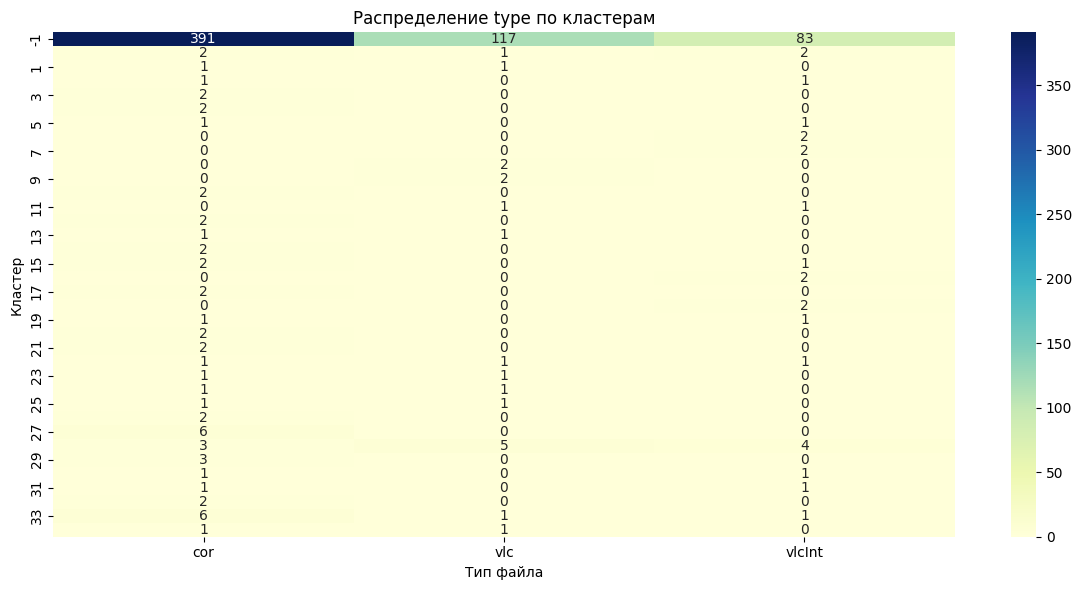

In [31]:
# Распределение type по кластерам
distribution = final_df.groupby('DBSCAN')['type'].value_counts().unstack(fill_value=0)
print("Распределение типов по кластерам:")
print(distribution)

# Визуализация в виде тепловой карты
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.heatmap(distribution, annot=True, cmap="YlGnBu", fmt=".0f")
plt.title("Распределение type по кластерам")
plt.xlabel("Тип файла")
plt.ylabel("Кластер")
plt.tight_layout()
plt.show()